#Autogluon 商店销售额 - 时间序列预测

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import autogluon as ag
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [3]:
#数据预处理

# ============================================================================
# 数据加载模块
# ============================================================================

def load_all_data():
    """加载所有数据文件"""
    print("加载数据文件...")

    train = pd.read_csv('train.csv', parse_dates=['date'])
    test = pd.read_csv('test.csv', parse_dates=['date'])
    oil = pd.read_csv('oil.csv', parse_dates=['date'])
    stores = pd.read_csv('stores.csv')
    holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])

    print(f"训练数据: {train.shape}")
    print(f"测试数据: {test.shape}")
    print(f"石油数据: {oil.shape}")
    print(f"店铺数据: {stores.shape}")
    print(f"节假日数据: {holidays.shape}")

    return train, test, oil, stores, holidays

# ============================================================================
# 外部数据预处理模块
# ============================================================================

def preprocess_oil_data(oil, start_date, end_date):
    """处理石油价格数据"""
    print("处理石油价格数据...")

    # 重命名列以避免混淆
    oil = oil.rename(columns={'dcoilwtico': 'oil_price'})

    # 创建完整的日期范围
    full_dates = pd.DataFrame({'date': pd.date_range(start_date, end_date)})
    oil = full_dates.merge(oil, on='date', how='left')

    # 处理缺失值 - 使用前向填充然后后向填充
    oil['oil_price'] = oil['oil_price'].fillna(method='ffill').fillna(method='bfill')

    # 如果还有缺失值，用均值填充
    if oil['oil_price'].isna().any():
        oil['oil_price'] = oil['oil_price'].fillna(oil['oil_price'].mean())

    print(f"石油价格数据处理完成，缺失值: {oil['oil_price'].isna().sum()}")

    return oil

def preprocess_holidays(holidays):
    """处理节假日数据"""
    print("处理节假日数据...")

    # 过滤出国家级节假日，排除转移的节假日
    national_holidays = holidays[
        (holidays['locale'] == 'National') &
        (holidays['transferred'] == False)
    ].copy()

    print(f"筛选出 {len(national_holidays)} 个国家级节假日")

    # 创建基础节假日标识
    holiday_features = national_holidays[['date']].drop_duplicates()
    holiday_features['is_holiday'] = 1

    # 创建重要节假日的具体标识
    important_holidays_map = {
        'Christmas': ['navidad', 'christmas'],
        'New Year': ['año', 'year'],
        'Mother Day': ['madre', 'mother'],
        'Labor Day': ['trabajo', 'labor'],
        'Independence': ['independencia', 'independence'],
        'Carnival': ['carnaval', 'carnival']
    }

    for holiday_name, keywords in important_holidays_map.items():
        # 查找包含关键词的节假日
        mask = national_holidays['description'].str.lower().str.contains('|'.join(keywords), na=False)
        if mask.any():
            col_name = f'is_{holiday_name.lower().replace(" ", "_")}'
            specific_dates = national_holidays[mask][['date']].drop_duplicates()
            specific_dates[col_name] = 1
            holiday_features = holiday_features.merge(specific_dates, on='date', how='left')

    # 填充缺失值
    holiday_cols = [col for col in holiday_features.columns if col.startswith('is_')]
    for col in holiday_cols:
        holiday_features[col] = holiday_features[col].fillna(0).astype(int)

    print(f"创建节假日特征: {holiday_cols}")

    return holiday_features

def preprocess_stores(stores):
    """处理店铺数据"""
    print("处理店铺数据...")

    stores_clean = stores.copy()

    # 处理缺失值
    stores_clean['city'] = stores_clean['city'].fillna('Unknown')
    stores_clean['state'] = stores_clean['state'].fillna('Unknown')
    stores_clean['type'] = stores_clean['type'].fillna('Unknown')
    stores_clean['cluster'] = stores_clean['cluster'].fillna(0)

    print(f"店铺数据处理完成: {stores_clean.shape}")

    return stores_clean

# ============================================================================
# 时间特征创建模块
# ============================================================================

def create_time_features(df):
    """创建时间相关特征"""
    print("创建时间特征...")

    df = df.copy()

    # 基础时间特征
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['quarter'] = df['date'].dt.quarter

    # 周末标识
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # 月份开始和结束
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

    # 季度开始和结束
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)

    # 发薪日特征（基于厄瓜多尔发薪习惯：15号和月末）
    df['is_payday'] = ((df['date'].dt.day == 15) | df['date'].dt.is_month_end).astype(int)

    # 发薪后几天（消费可能增加）
    df['is_day_after_payday'] = ((df['date'].dt.day == 16) | (df['date'].dt.day == 1)).astype(int)
    df['is_payday_week'] = (
        ((df['date'].dt.day >= 15) & (df['date'].dt.day <= 21)) |
        ((df['date'].dt.day >= 1) & (df['date'].dt.day <= 7))
    ).astype(int)

    print("时间特征创建完成")

    return df

# ============================================================================
# 主数据处理模块
# ============================================================================

def process_main_data(train, test, oil, stores, holidays):
    """主要数据处理和合并函数"""
    print("开始主要数据处理...")

    # 标记训练和测试数据
    train['dataset'] = 'train'
    test['dataset'] = 'test'
    test['sales'] = np.nan  # 测试集没有销售数据

    # 合并所有数据
    all_data = pd.concat([train, test], ignore_index=True)

    # 基础数据清理
    print("基础数据清理...")
    all_data['onpromotion'] = all_data['onpromotion'].fillna(0).astype(int)
    all_data['sales'] = all_data['sales'].clip(lower=0)  # 负销售值处理为0

    # 创建唯一的时间序列标识符
    all_data['item_id'] = all_data['store_nbr'].astype(str) + '_' + all_data['family']

    # 获取时间范围
    start_date = all_data['date'].min()
    end_date = all_data['date'].max()
    print(f"数据时间范围: {start_date} 到 {end_date}")

    # 处理和合并外部数据
    print("合并外部数据...")

    # 1. 石油价格数据
    oil_processed = preprocess_oil_data(oil, start_date, end_date)
    all_data = all_data.merge(oil_processed, on='date', how='left')

    # 2. 店铺数据
    stores_processed = preprocess_stores(stores)
    all_data = all_data.merge(stores_processed, on='store_nbr', how='left')

    # 3. 节假日数据
    holidays_processed = preprocess_holidays(holidays)
    all_data = all_data.merge(holidays_processed, on='date', how='left')

    # 填充节假日特征的缺失值
    holiday_cols = [col for col in all_data.columns if col.startswith('is_')]
    for col in holiday_cols:
        all_data[col] = all_data[col].fillna(0).astype(int)

    # 4. 创建时间特征
    all_data = create_time_features(all_data)

    # 最终数据清理
    print("最终数据清理...")

    # 处理分类变量的缺失值
    categorical_cols = ['city', 'state', 'type']
    for col in categorical_cols:
        all_data[col] = all_data[col].fillna('Unknown')

    # 处理数值变量的缺失值
    numerical_cols = ['cluster', 'oil_price']
    for col in numerical_cols:
        if col in all_data.columns:
            all_data[col] = all_data[col].fillna(0)

    # 分离训练和测试数据
    train_processed = all_data[all_data['dataset'] == 'train'].copy()
    test_processed = all_data[all_data['dataset'] == 'test'].copy()

    # 移除临时列
    train_processed = train_processed.drop('dataset', axis=1)
    test_processed = test_processed.drop(['dataset', 'sales'], axis=1)

    print(f"训练数据处理完成: {train_processed.shape}")
    print(f"测试数据处理完成: {test_processed.shape}")

    return train_processed, test_processed

# ============================================================================
# 特征列表和数据概览
# ============================================================================

def get_feature_info(df):
    """获取特征信息概览"""
    print("\n" + "="*60)
    print("数据特征概览")
    print("="*60)

    # 按类型分组特征
    feature_groups = {
        '基础特征': ['item_id', 'store_nbr', 'family', 'onpromotion'],
        '时间特征': ['date', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter'],
        '时间标识': ['is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end'],
        '发薪特征': ['is_payday', 'is_day_after_payday', 'is_payday_week'],
        '店铺特征': ['city', 'state', 'type', 'cluster'],
        '外部特征': ['oil_price'],
        '节假日特征': [col for col in df.columns if col.startswith('is_') and 'payday' not in col and 'weekend' not in col and 'month' not in col and 'quarter' not in col]
    }

    for group_name, features in feature_groups.items():
        available_features = [f for f in features if f in df.columns]
        if available_features:
            print(f"\n{group_name}: {available_features}")

    print(f"\n总特征数量: {len(df.columns)}")
    print(f"数据形状: {df.shape}")
    print(f"时间序列数量: {df['item_id'].nunique()}")
    print(f"时间范围: {df['date'].min()} 到 {df['date'].max()}")

    # 检查缺失值
    missing_info = df.isnull().sum()
    if missing_info.sum() > 0:
        print(f"\n缺失值情况:")
        for col, missing_count in missing_info[missing_info > 0].items():
            print(f"  {col}: {missing_count}")
    else:
        print(f"\n✓ 无缺失值")

    print("="*60)

# ============================================================================
# 完整预处理流程
# ============================================================================

def run_preprocessing():
    """运行完整的数据预处理流程"""
    print("="*60)
    print("Store Sales 数据预处理")
    print("="*60)

    try:
        # 1. 加载数据
        train, test, oil, stores, holidays = load_all_data()

        # 2. 处理数据
        train_processed, test_processed = process_main_data(train, test, oil, stores, holidays)

        # 3. 显示特征信息
        get_feature_info(train_processed)

        print("\n✓ 数据预处理完成！")
        print("✓ 训练数据已准备就绪")
        print("✓ 测试数据已准备就绪")

        return train_processed, test_processed

    except Exception as e:
        print(f"❌ 预处理过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()
        raise e

# ============================================================================
# 数据采样工具（用于快速模型训练）
# ============================================================================

def sample_data(train_df, test_df, n_stores=5, n_families=10, start_date='2017-01-01'):
    """采样数据用于快速测试"""
    print(f"采样数据: {n_stores}个店铺, {n_families}个商品类别, 从{start_date}开始")

    # 选择店铺和商品类别
    sample_stores = train_df['store_nbr'].unique()[:n_stores]
    sample_families = train_df['family'].unique()[:n_families]

    # 筛选数据
    train_sample = train_df[
        (train_df['store_nbr'].isin(sample_stores)) &
        (train_df['family'].isin(sample_families)) &
        (train_df['date'] >= start_date)
    ].copy()

    test_sample = test_df[
        (test_df['store_nbr'].isin(sample_stores)) &
        (test_df['family'].isin(sample_families))
    ].copy()

    print(f"采样后训练数据: {train_sample.shape}")
    print(f"采样后测试数据: {test_sample.shape}")

    return train_sample, test_sample

# ============================================================================
# 使用示例
# ============================================================================

if __name__ == "__main__":
    # 运行完整预处理
    train_processed,test_processed = run_preprocessing()

    # 可选：生成采样数据用于快速测试
    # train_sample, test_sample = sample_data(train_processed, test_processed)

    print("\n" + "="*60)
    print("预处理完成！现在可以进行模型训练了。")
    print("="*60)
    print("\n变量说明:")
    print("- train_processed: 处理后的训练数据")
    print("- test_processed: 处理后的测试数据")
    print("- 包含所有必要的特征和外部数据")
    print("- 所有缺失值已处理")
    print("- 可直接用于AutoGluon训练")

Store Sales 数据预处理
加载数据文件...
训练数据: (3000888, 6)
测试数据: (28512, 5)
石油数据: (1218, 2)
店铺数据: (54, 5)
节假日数据: (350, 6)
开始主要数据处理...
基础数据清理...
数据时间范围: 2013-01-01 00:00:00 到 2017-08-31 00:00:00
合并外部数据...
处理石油价格数据...
石油价格数据处理完成，缺失值: 0
处理店铺数据...
店铺数据处理完成: (54, 5)
处理节假日数据...
筛选出 166 个国家级节假日
创建节假日特征: ['is_holiday', 'is_christmas', 'is_mother_day', 'is_labor_day', 'is_independence', 'is_carnival']
创建时间特征...
时间特征创建完成
最终数据清理...
训练数据处理完成: (3000888, 33)
测试数据处理完成: (28512, 32)

数据特征概览

基础特征: ['item_id', 'store_nbr', 'family', 'onpromotion']

时间特征: ['date', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']

时间标识: ['is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end']

发薪特征: ['is_payday', 'is_day_after_payday', 'is_payday_week']

店铺特征: ['city', 'state', 'type', 'cluster']

外部特征: ['oil_price']

节假日特征: ['is_holiday', 'is_christmas', 'is_mother_day', 'is_labor_day', 'is_independence', 'is_carnival']

总特征数量: 33
数据形状: (3000888, 33)
时间序列数量: 1782
时间范围: 2013-01-

In [19]:
# 按时间分割获取训练，评估和测试集
split_date = '2017-07-31'  # 用7月31日作为分割点

data_train = train_processed[train_processed['date'] < split_date]
data_eval = train_processed[train_processed['date'] >= split_date]
data_test = test_processed.copy()

print("重新分割后:")
print("训练集开始日期:", data_train['date'].min())
print("训练集最后日期:", data_train['date'].max())
print("评估集开始日期:", data_eval['date'].min())
print("评估集结束日期:", data_eval['date'].max())
print("测试集开始日期:", test_processed['date'].min())
print("测试集最后日期:", test_processed['date'].max())
print(data_train.shape,data_eval.shape,data_test.shape)

重新分割后:
训练集开始日期: 2013-01-01 00:00:00
训练集最后日期: 2017-07-30 00:00:00
评估集开始日期: 2017-07-31 00:00:00
评估集结束日期: 2017-08-15 00:00:00
测试集开始日期: 2017-08-16 00:00:00
测试集最后日期: 2017-08-31 00:00:00
(2972376, 33) (28512, 33) (28512, 32)


In [28]:
#数据转为Autogluon要求的格式

# 创建训练集时间序列数据
train_ts = TimeSeriesDataFrame.from_data_frame(
    data_train,
    id_column='item_id',
    timestamp_column='date'
)

# 创建评估集时间序列数据
eval_ts = TimeSeriesDataFrame.from_data_frame(
    data_eval,
    id_column='item_id',
    timestamp_column='date'
)

full_data = pd.concat([data_train, data_eval])
full_ts = TimeSeriesDataFrame.from_data_frame(
    full_data,
    id_column='item_id',
    timestamp_column='date'
)

In [21]:
#开始模型构建训练
model = TimeSeriesPredictor(
    prediction_length=16,
    path="store_sales_model",  # 模型保存路径
    target="sales",           # 目标列
    eval_metric="RMSE",        # 评估指标
    freq='D'  # 每日频率
)

model.fit(
    train_data=train_ts,
    presets='medium_quality',
    time_limit=1800
)

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to '/content/store_sales_model'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       3.32 GB / 12.67 GB (26.2%)
Disk Space Avail:   182.37 GB / 225.83 GB (80.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'D',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 16,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'sales',
 'time_limit': 1800,
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to f

In [29]:
predictions = model.predict(full_ts)
predictions.head()

data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean       0.1  ...       0.8        0.9
item_id      timestamp                       ...                     
1_AUTOMOTIVE 2017-08-16  4.610515  0.668573  ...  7.531704   9.216449
             2017-08-17  5.116747  0.068919  ...  8.783351  10.846525
             2017-08-18  4.527394 -1.354994  ...  8.710287  11.044089
             2017-08-19  5.358614 -1.201450  ...  9.950414  12.505710
             2017-08-20  2.975055 -4.174008  ...  7.935812  10.693292

[5 rows x 10 columns]

data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


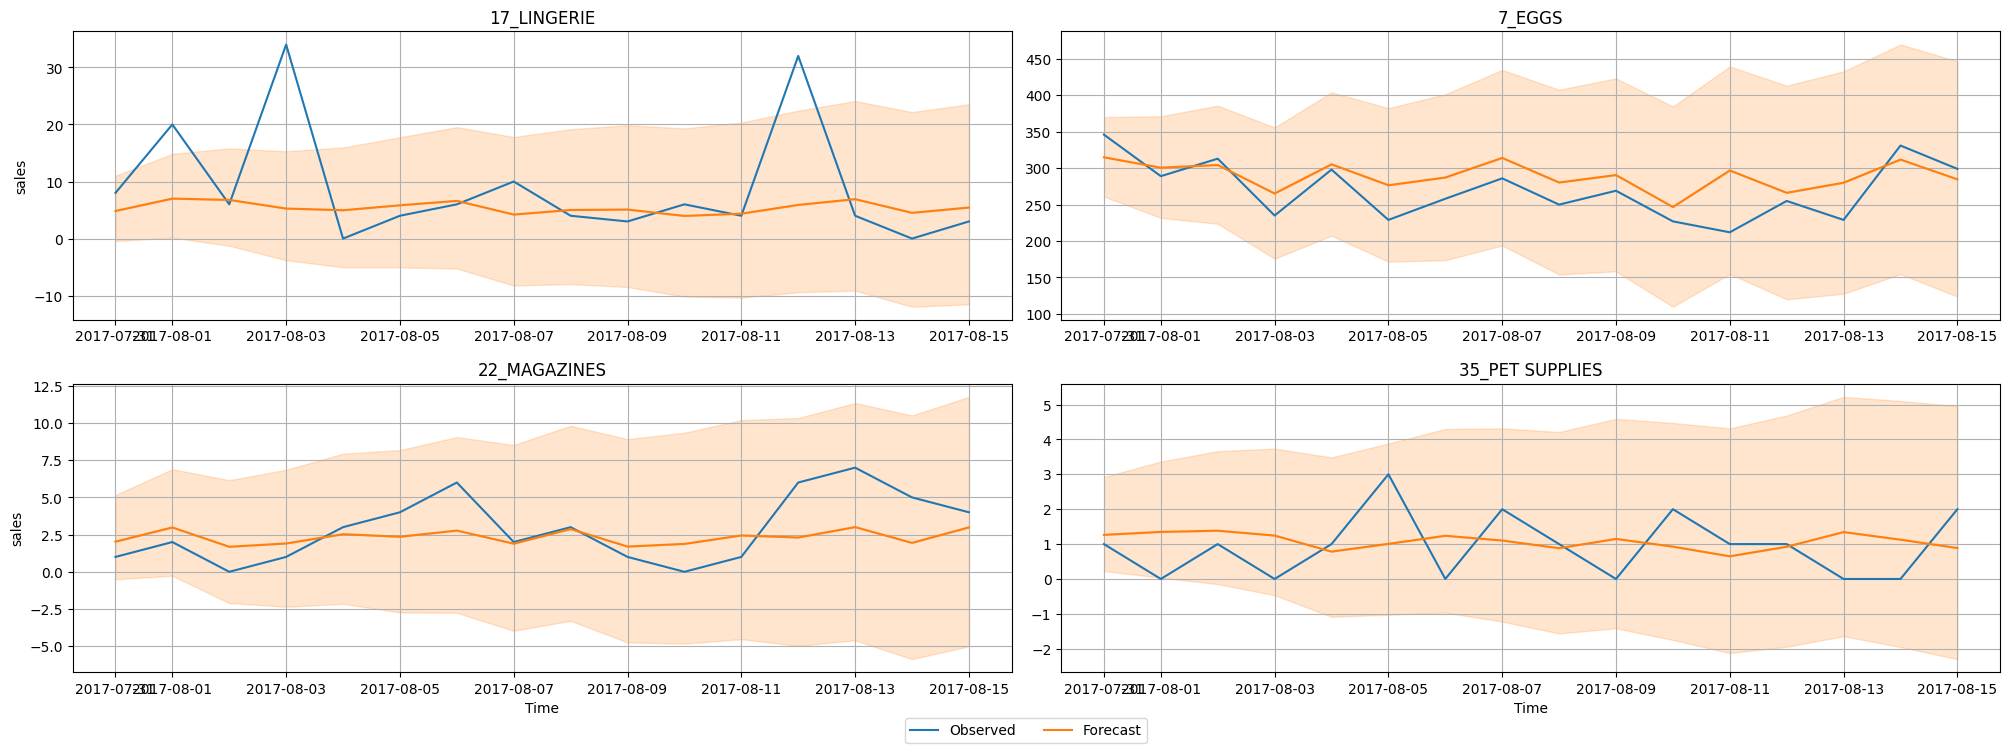

In [35]:
# 可视化评估集的预测效果
train_predictions = model.predict(train_ts)  # 这个预测评估集时间段
model.plot(
    eval_ts, #评估集
    train_predictions, #训练集
    quantile_levels=[0.1, 0.9],
    max_history_length=100,
    max_num_item_ids=4
)
plt.show()

In [34]:
# 评估模型在评估集
model.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-207.517431,255.247698,4.403296,7
1,RecursiveTabular,-219.994370,11.598553,244.039448,3
2,Chronos[bolt_small],-225.182344,213.668644,3.487943,5
3,DirectTabular,-227.107776,6.785237,81.459761,4
4,TemporalFusionTransformer,-254.234541,9.362591,279.603146,6
5,SeasonalNaive,-266.721276,5.745002,5.665770,2
6,Naive,-473.947309,8.087670,5.251883,1


In [33]:
# 5. 创建正确的提交文件
submission = pd.DataFrame({
    'id': data_test['id'],
    'sales': predictions['mean'].values  # 用.values获取纯数值
})

submission['sales'] = submission['sales'].clip(lower=0)
submission.to_csv('submission_correct.csv', index=False)

print(f"提交文件长度: {len(submission)}")
print("提交文件前5行:")
print(submission.head())

提交文件长度: 28512
提交文件前5行:
              id     sales
3000888  3000888  4.610515
3000889  3000889  5.116747
3000890  3000890  4.527394
3000891  3000891  5.358614
3000892  3000892  2.975055
